In [1]:
import pandas as pd
import numpy as np
import os
import sys
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [40]:
import plot_help

In [42]:
from importlib import reload

In [137]:
plot_help = reload(plot_help)

# 0. Paths

In [15]:
PATH_TRAINING = os.path.join("..","training")
PATH_OUTPUTS = os.path.join(PATH_TRAINING,"outputs")
PATH_MASTERS = os.path.join(PATH_TRAINING, "data")

In [25]:
# Number of subimgs given one jgp spectrogram
num_subimgs = 3

# 1. Load data

## 1.1 Dictionary of embeddings

In [10]:
filename = "dict_catalan_v1.pickle"

In [23]:
PATH_FILENAME = os.path.join(PATH_OUTPUTS, filename)
with open(PATH_FILENAME, 'rb') as handle:
    dict_pred = pickle.load(handle)

In [31]:
num_artists = len(dict_pred.keys())

## 1.2 Master artist and track

In [18]:
# Master Artist
filename_csv = 'master_artist.csv'
path_csv = os.path.join(PATH_MASTERS, filename_csv)
m_artist = pd.read_csv(path_csv,sep=",")

# Master track
filename_csv = 'master_track.csv'
path_csv = os.path.join(PATH_MASTERS, filename_csv)
m_track = pd.read_csv(path_csv,sep=",")

## 1.3 Dataframe of embeddings

In [26]:
values = []
edgecolors = {'train': "#1A1717", 'test': "#EE3811"} # test: rojo, train: negro

for art in tqdm(dict_pred):
    for tr in dict_pred[art]:
        for jj in range(num_subimgs - 1):
            size = dict_pred[art][tr][jj]["size_point"]
            alpha = edgecolors["train"] if size == 50 else edgecolors["test"]
            l = [art, tr, jj, size, alpha]
            for embed_val in dict_pred[art][tr][jj]["embedding"]:
                l.append(embed_val)
            values.append(l)

In [27]:
# Create the dataframe for T-SNE
df_tsne = pd.DataFrame(values, columns = ["art","img","subimg","size_point","alpha", "embed"])

# Get the track_id from the image file
df_tsne["tr"] = df_tsne['img'].apply(lambda x: x.split("__")[0])

# Get the artist name
df_tsne = pd.merge(df_tsne, m_artist[["artist_id","artist_name"]], 
                   left_on = "art", right_on = "artist_id", how = "left")

# Get the track name
df_tsne = pd.merge(df_tsne, m_track[["track_id","track_name"]], 
                   left_on = "tr", right_on = "track_id", how = "left")

In [28]:
# Put the embeddings into a matrix for t-SNE modelling
vals = []
for ll in df_tsne.embed:
    vals.append(list(ll))
vals_arr = np.array(vals)

# 2. t-SNE

In [29]:
tsne_model = TSNE()
X_2d = tsne_model.fit_transform(vals_arr)

In [32]:
# Get TRUE artists
original_artist = np.array(df_tsne.artist_name)

# Colors
all_colors = ["#800000","#9A6324","#808000","#EFD2CB","#469990",
                "#000075","#000000","#e6194B","#f58231","#ffe119","#bfef45",
                "#3cb44b","#42d4f4","#4363d8","#911eb4","#f032e6","#a9a9a9","#fabed4",
                "#ffd8b1","#fffac8","#aaffc3","#dcbeff","#0B0033","#370031","#832232","#CE8964","#EAF27C"
                ]

colors_extra = all_colors[:num_artists]

# 2. UMAP

In [113]:
#!pip install umap-learn

In [114]:
import umap

In [116]:
reducer = umap.UMAP()

In [117]:
df_umap = reducer.fit_transform(vals_arr)

# 3. Plot embeddings

In [49]:
plot_help = reload(plot_help)

## 3.1 Training

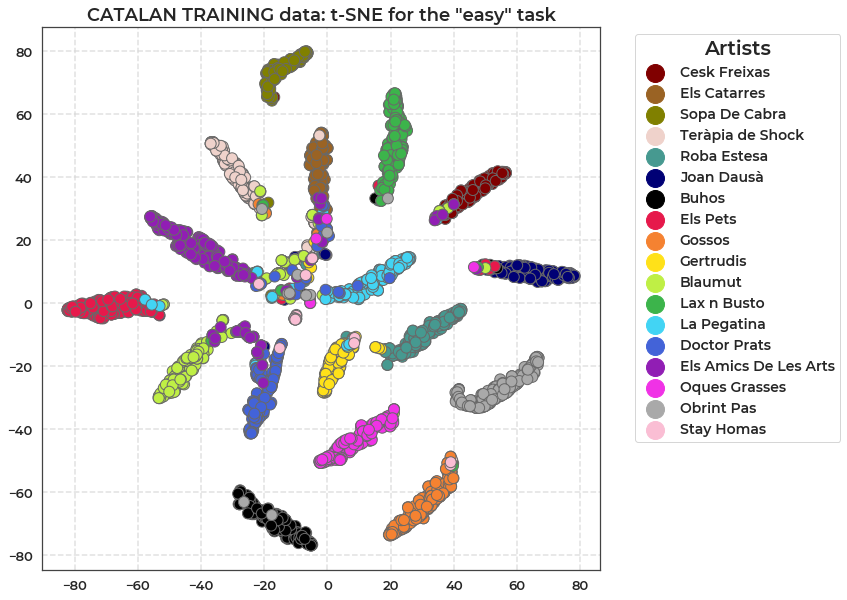

In [236]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN TRAINING data: t-SNE for the "easy" task', fontsize = 18)
lgnd = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)

#### UMAP

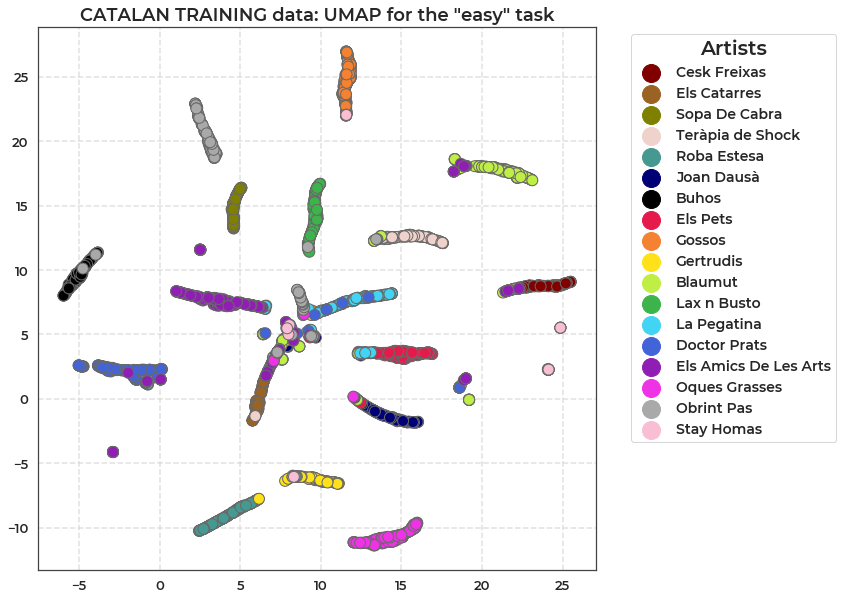

In [237]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN TRAINING data: UMAP for the "easy" task', fontsize = 18)
lgnd = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)

## 3.2 Testing

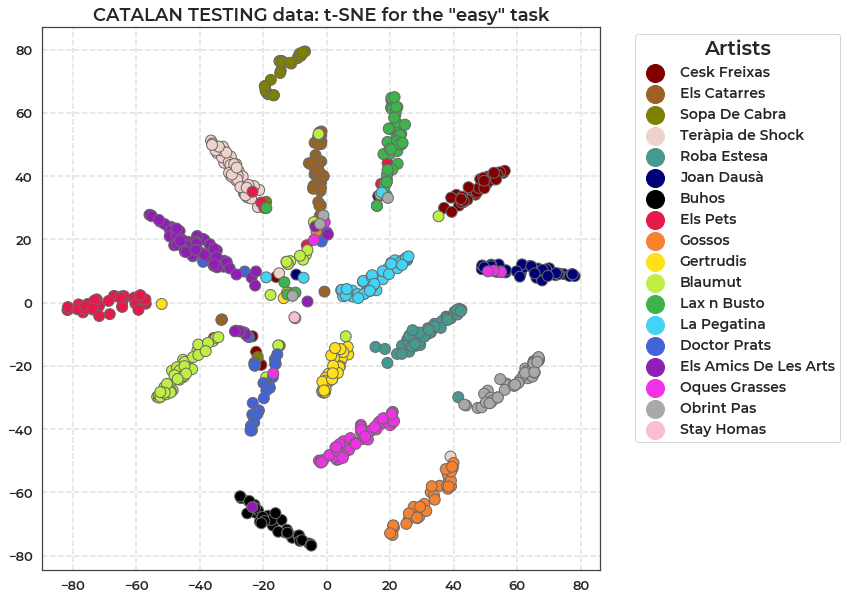

In [238]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN TESTING data: t-SNE for the "easy" task', fontsize = 18)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)

#### UMAP

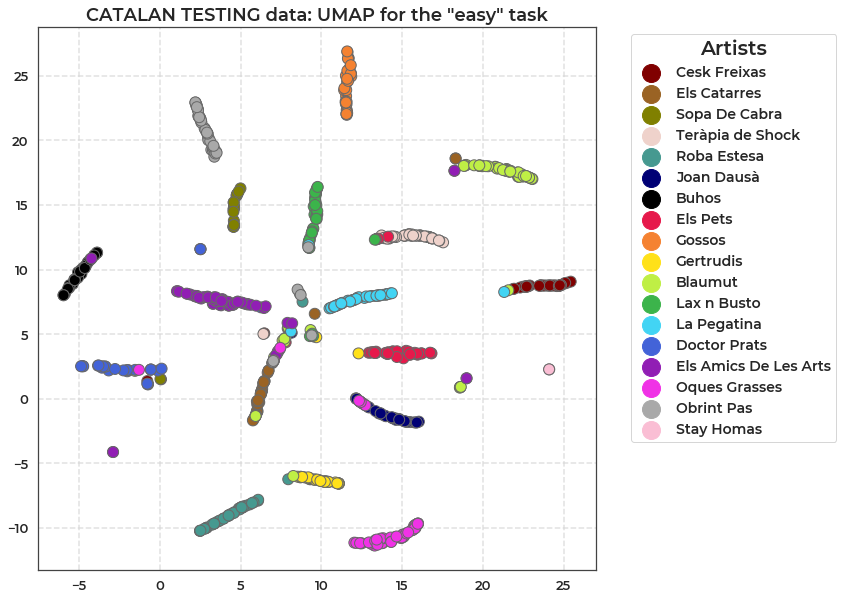

In [239]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 120, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN TESTING data: UMAP for the "easy" task', fontsize = 18)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)

## 3.3 Train and Test

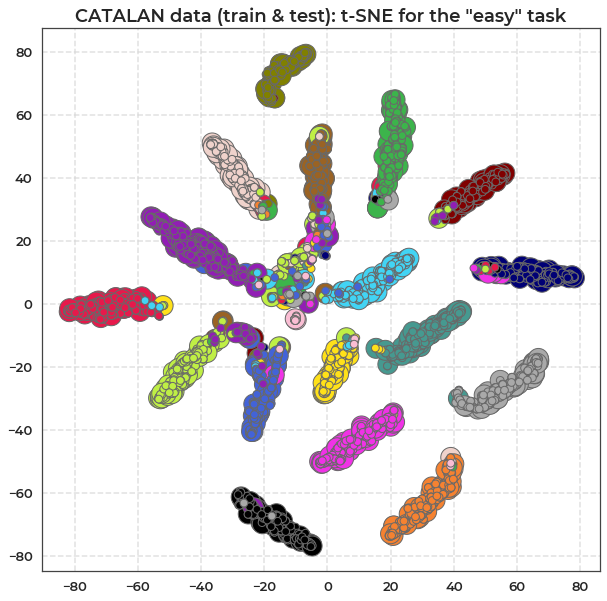

In [242]:
plt.figure(figsize=(10,10))

# Test
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 400, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN data (train & test): t-SNE for the "easy" task', fontsize = 18)#leg = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')
#Train
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=X_2d[mask_train, 0], y=X_2d[mask_train, 1], hue=original_artist[mask_train], 
                s= 60, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))

plt.legend([],[], frameon=False)
    

#### UMAP

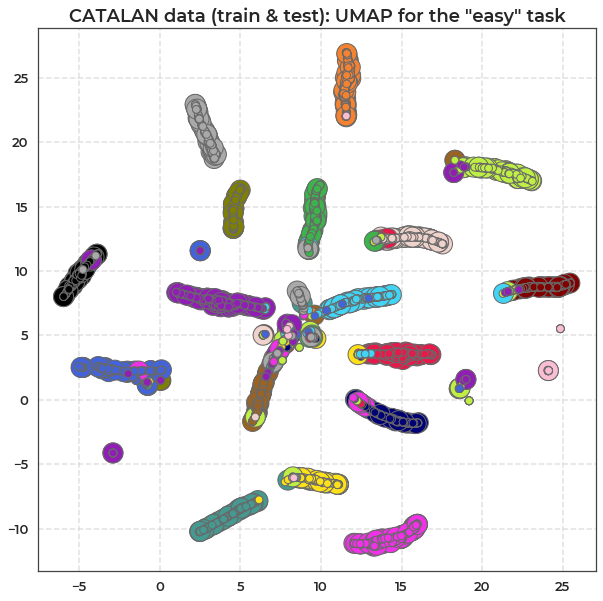

In [243]:
plt.figure(figsize=(10,10))

# Test
mask_train = np.array(df_tsne.size_point == 200)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 400, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN data (train & test): UMAP for the "easy" task', fontsize = 18)#leg = plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left')
#Train
mask_train = np.array(df_tsne.size_point == 50)
sns.scatterplot(x=df_umap[mask_train, 0], y=df_umap[mask_train, 1], hue=original_artist[mask_train], 
                s= 60, alpha = 1, 
                edgecolors=df_tsne.loc[mask_train, "alpha"], linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))

plt.legend([],[], frameon=False)
    

## 3.4 Examining One Artist

### Amics de les Arts

In [245]:
# Filter
art = "Els Amics De Les Arts"
mask_art = np.array((df_tsne.artist_name == art))
df_tsne_art = df_tsne.loc[mask_art]

# Legend values
original_track = df_tsne_art.track_name
num_tracks = len(original_track.unique())

(25.0, 0.0)

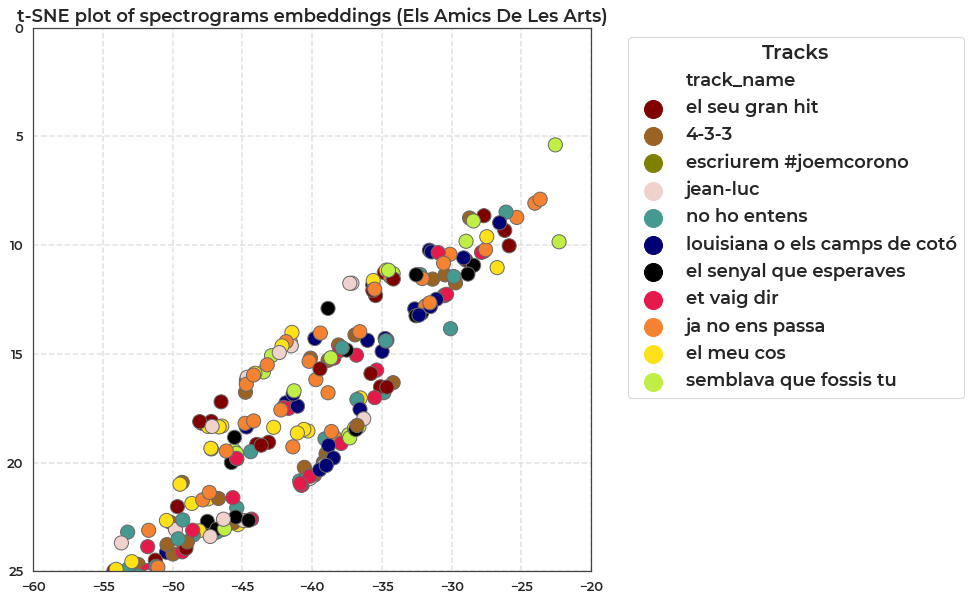

In [246]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne_art.size_point == 50)
sns.scatterplot(x=X_2d[mask_art, 0], y=X_2d[mask_art, 1], hue=original_track, 
                alpha = 1, linewidth = 1, edgecolor = "#696969",
                s = 200,
               palette=sns.color_palette(colors_extra[:num_tracks]))
plt.title(f't-SNE plot of spectrograms embeddings ({art})', fontsize = 18)
lgnd = plt.legend(title="Tracks", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3, fontsize = 18)

plt.xlim(-60,-20)
plt.ylim(25,0)

#### UMAP

(6.0, 9.0)

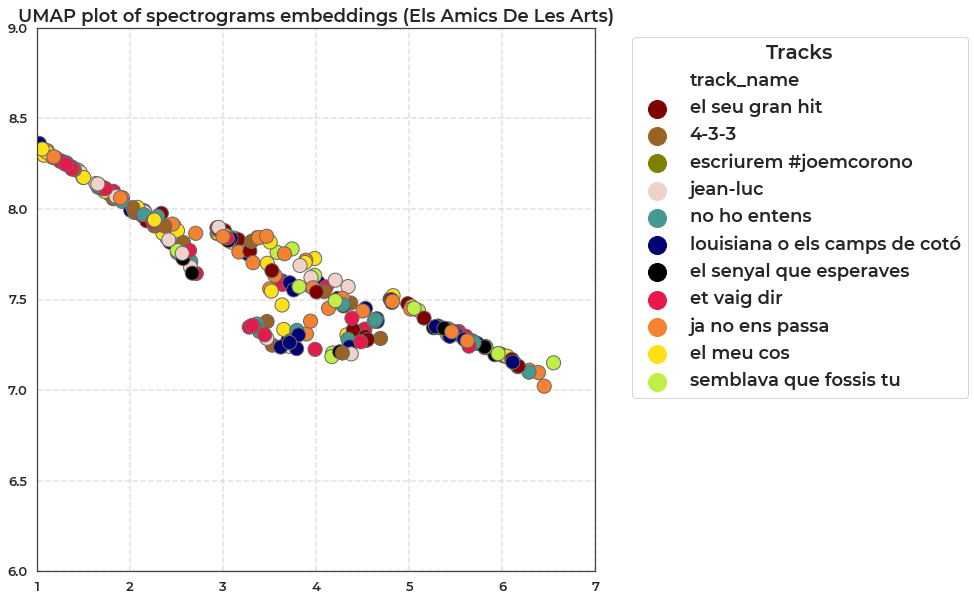

In [247]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne_art.size_point == 50)
sns.scatterplot(x=df_umap[mask_art, 0], y=df_umap[mask_art, 1], hue=original_track, 
                alpha = 1, linewidth = 1, edgecolor = "#696969",s = 200,
               palette=sns.color_palette(colors_extra[:num_tracks]))
plt.title(f'UMAP plot of spectrograms embeddings ({art})', fontsize = 18)
lgnd = plt.legend(title="Tracks", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3, fontsize = 18)

plt.xlim(1,7)
plt.ylim(6,9)

###  Buhos

In [248]:
# Filter
art = "Buhos"
mask_art = np.array((df_tsne.artist_name == art))
df_tsne_art = df_tsne.loc[mask_art]

# Legend values
original_track = df_tsne_art.track_name
num_tracks = len(original_track.unique())

(-59.0, -80.0)

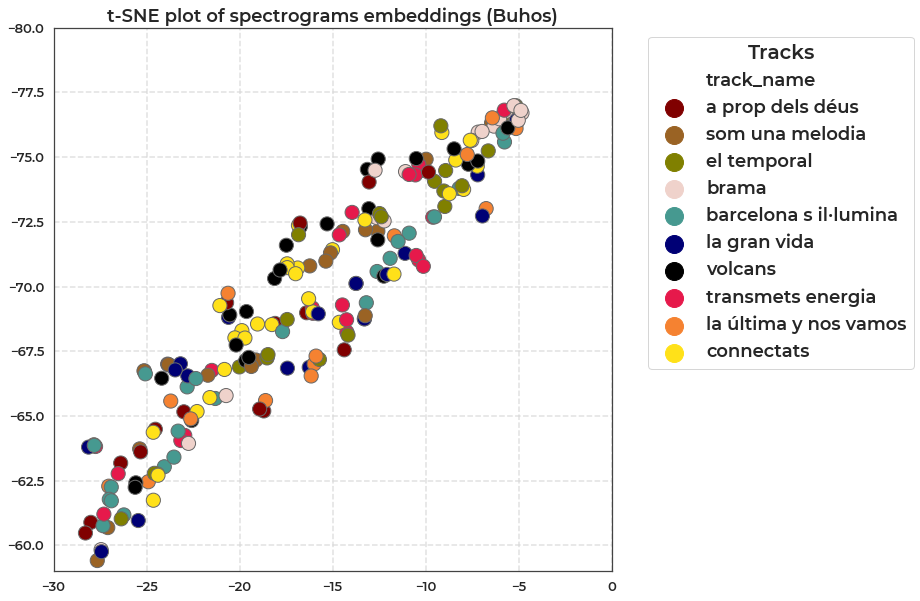

In [249]:
plt.figure(figsize=(10,10))
mask_train = np.array(df_tsne_art.size_point == 50)
sns.scatterplot(x=X_2d[mask_art, 0], y=X_2d[mask_art, 1], hue=original_track, 
                alpha = 1, linewidth = 1, edgecolor = "#696969", s = 200,
               palette=sns.color_palette(colors_extra[:num_tracks]))
plt.title(f't-SNE plot of spectrograms embeddings ({art})', fontsize = 18)
lgnd = plt.legend(title="Tracks", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3, fontsize = 18)

plt.xlim(-30,0)
plt.ylim(-59,-80)

# 4. K-Means

In [250]:
from sklearn.cluster import KMeans
from sklearn.metrics import multilabel_confusion_matrix

In [253]:
# Reduced dimensionality
df_kmeans = df_tsne.copy()
df_kmeans["umap1"] = df_umap[:,0]
df_kmeans["umap2"] = df_umap[:,1]
df_kmeans["tsne1"] = X_2d[:,0]
df_kmeans["tsne2"] = X_2d[:,1]

# X data
X_kmeans = df_kmeans[["umap1","umap2"]]

# KMeans
kmeans = KMeans(n_clusters=num_artists, random_state=0).fit(X_kmeans)

# Get the predicted cluster
df_kmeans["pred_umap"] = kmeans.labels_

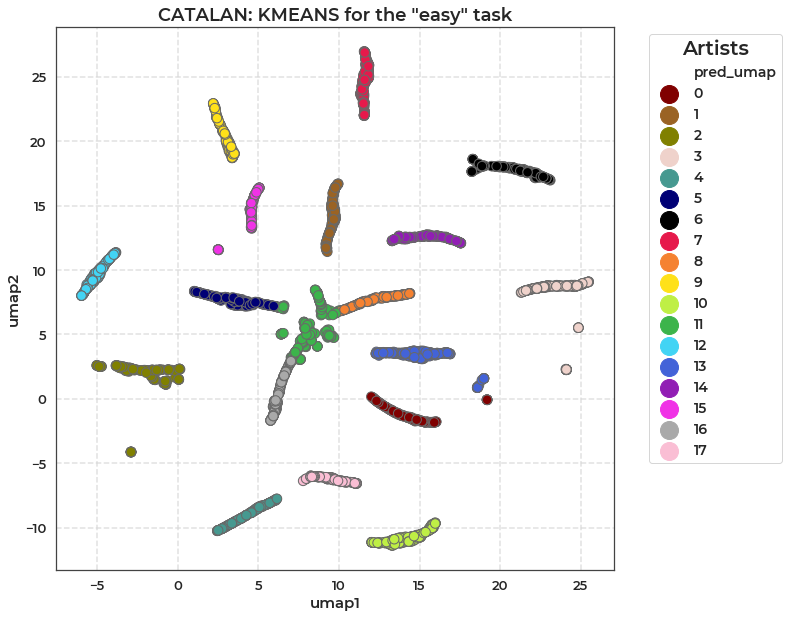

In [255]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=df_kmeans["umap1"], y=df_kmeans["umap2"], hue=df_kmeans["pred_umap"], 
                s= 90, alpha = 1,  linewidth = 1, edgecolor = "#696969",
                palette=sns.color_palette(colors_extra))
plt.title('CATALAN: KMEANS for the "easy" task', fontsize = 18)
plt.legend(title="Artists", bbox_to_anchor=(1.05, 1), loc='upper left', markerscale = 3)

## 4.1 Confusion Matrix for artist classification

In [149]:
# Cluster labels
sort_labels = np.sort(df_kmeans["pred_umap"].unique())

# Artist labels
sort_artists = np.sort(df_kmeans["artist_name"].unique())

# Manually create the confusion matrix
mat = []

for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        df_kmeans_filt = df_kmeans[mask_art & mask_lab]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

Text(0.5, 63.5, '\n Cluster')

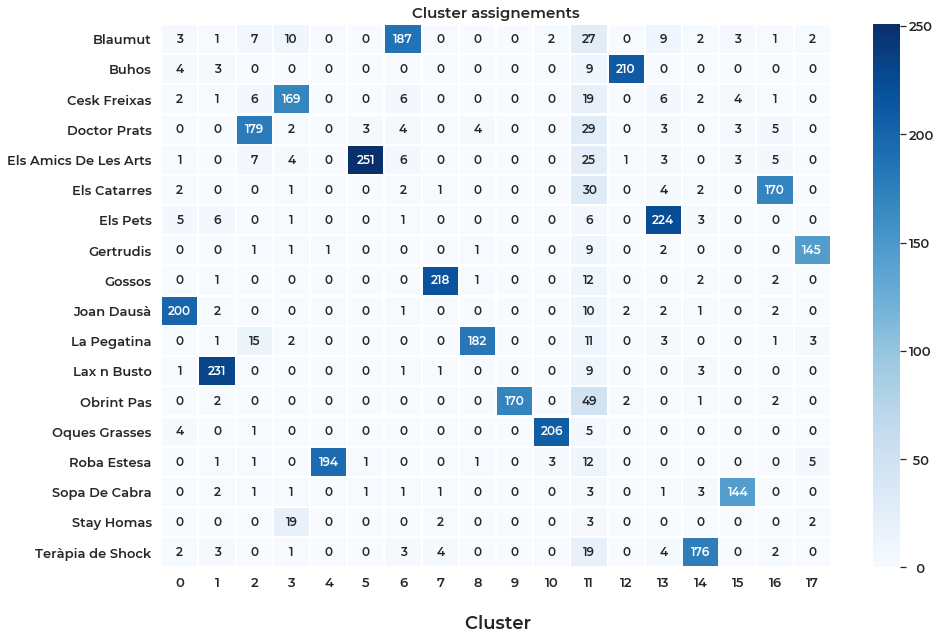

In [177]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title("Cluster assignements")
axh = sns.heatmap(df_mat, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Cluster", fontsize = 18)

## 4.2 Confusion matrix for artist tracks misclassification

In [193]:
# Filter
artist_name_query = "Buhos"
mask_art = np.array((df_kmeans.artist_name == artist_name_query))
df_cm_art = df_kmeans.loc[mask_art]

In [194]:
# Cluster labels
sort_labels = np.sort(df_cm_art["pred_umap"].unique())

# Track labels
sort_tracks = np.sort(df_cm_art["track_name"].unique())

In [195]:
# Manually create the confusion matrix
mat = []

for art in sort_tracks:
    art_list = []
    for lab in sort_labels:
        mask_art = df_cm_art["track_name"] == art
        mask_lab = df_cm_art["pred_umap"] == lab
        df_kmeans_filt = df_cm_art[mask_art & mask_lab]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_track = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_tracks)

Text(0.5, 63.5, '\n Cluster')

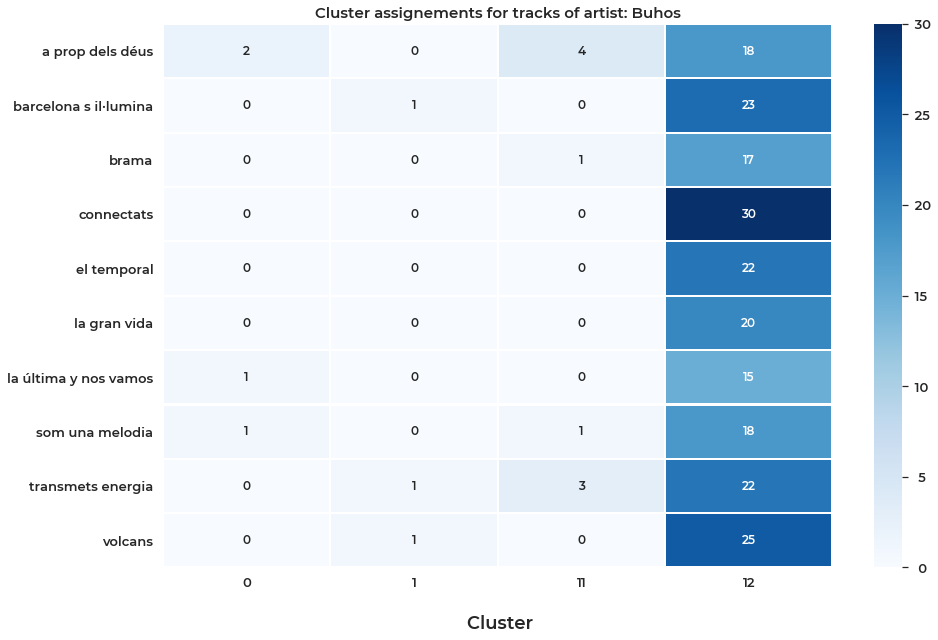

In [197]:
# Draw a heatmap with the numeric values in each cell
f, ax = plt.subplots(figsize=(15, 10))
plt.title(f"Cluster assignements for tracks of artist: {artist_name_query}")
axh = sns.heatmap(df_mat_track, annot=True, fmt=".3g", linewidths=1.2, ax=ax, cmap="Blues",
                  cbar_kws={'format': '%3d'}, annot_kws={"size": 12})
plt.xlabel("\n Cluster", fontsize = 18)

#### Pinpoint which is the part of the song that it's miss classified

In [200]:
cluster_mistaken = 1
track_mistake = "volcans"
mask_track_mist = df_cm_art["track_name"] == track_mistake
mask_cluster_mistake = df_cm_art["pred_umap"] == cluster_mistaken
df_cm_art[mask_track_mist & mask_cluster_mistake][["img", "subimg"]]

,img,subimg
1314,5AnPNGsEt7cOjSGmBDq8e2__1__20__50.jpg,0


## 4.3 Accuracy by artist

In [256]:
acc_list = list()

# TOTAL
for ii_art in df_mat.index:
    idx_max_cluster = df_mat.loc[ii_art].argmax()
    CORRECT = df_mat.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list.append(acc)
    
df_acc_artists = pd.DataFrame(acc_list, index = df_mat.index, columns = ["accuracy"])

In [257]:
df_acc_artists.sort_values("accuracy", ascending = False)

,accuracy
Oques Grasses,0.954
Lax n Busto,0.939
Buhos,0.929
Gossos,0.924
Sopa De Cabra,0.911
Els Pets,0.911
Joan Dausà,0.909
Gertrudis,0.906
Roba Estesa,0.890
La Pegatina,0.835


### Accuracy by training / testing

In [230]:
# Cluster labels
sort_labels = np.sort(df_kmeans["pred_umap"].unique())

# Artist labels
sort_artists = np.sort(df_kmeans["artist_name"].unique())

# Manually create the confusion matrix
mat = []

# TRAIN
for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        mask_train = df_kmeans["size_point"] == 50
        df_kmeans_filt = df_kmeans[mask_art & mask_lab & mask_train]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_train = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

# TEST
mat = []

# TRAIN
for art in sort_artists:
    art_list = []
    for lab in sort_labels:
        mask_art = df_kmeans["artist_name"] == art
        mask_lab = df_kmeans["pred_umap"] == lab
        mask_train = df_kmeans["size_point"] == 200
        df_kmeans_filt = df_kmeans[mask_art & mask_lab & mask_train]
        nums = df_kmeans_filt.shape[0]
        art_list.append(nums)
    mat.append(art_list)
    
# Set it as a pandas dataframe
df_mat_test = pd.DataFrame(np.array(mat), columns = sort_labels, index = sort_artists)

In [233]:
# TRAIN
acc_list_train = list()

for ii_art in df_mat_train.index:
    idx_max_cluster = df_mat_train.loc[ii_art].argmax()
    CORRECT = df_mat_train.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat_train.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list_train.append(acc)
    
# TEST
acc_list_test = list()

for ii_art in df_mat_test.index:
    idx_max_cluster = df_mat_test.loc[ii_art].argmax()
    CORRECT = df_mat_test.loc[ii_art][idx_max_cluster]
    TOTAL = df_mat_test.loc[ii_art].sum()
    acc = np.round(CORRECT / TOTAL,3)
    acc_list_test.append(acc)
    
df_acc_artists_train = pd.DataFrame(acc_list_train, index = df_mat_train.index, columns = ["accuracy_train"])
df_acc_artists_test = pd.DataFrame(acc_list_test, index = df_mat_test.index, columns = ["accuracy_test"])
#df_acc_train_test = pd.merge()

In [259]:
df_acc_final = pd.merge(df_acc_artists_train, df_acc_artists_test, left_index=True, right_index=True)
df_acc_final = pd.merge(df_acc_final, df_acc_artists, left_index=True, right_index=True)
df_acc_final.sort_values("accuracy_test", ascending = False)

,accuracy_train,accuracy_test,accuracy
Stay Homas,0.708,1.000,0.731
Buhos,0.922,0.971,0.929
Roba Estesa,0.875,0.952,0.890
La Pegatina,0.804,0.940,0.835
Joan Dausà,0.904,0.929,0.909
Gertrudis,0.898,0.929,0.906
Lax n Busto,0.944,0.917,0.939
Gossos,0.925,0.917,0.924
Oques Grasses,0.975,0.893,0.954
Teràpia de Shock,0.800,0.889,0.822
